In [4]:
import numpy as np
from scipy.optimize import minimize

H = np.matrix([1,0]) # H is a row
data = np.loadtxt('../Documents/ApplePriceTargets.txt')
y = np.matrix(data).T # column matrix, observations of Y
n = y.size # number of observations

def filtering(R, Q, A):
    '''
    Args:
        R (float): scalar variance of y|x
        Q (matrix 2x2): variance of x(k)|x(k-1)
        A (matrix 2x2): mean factor in x(k)|x(k-1)
    Returns:
        m_minus (matrix): 2xn dimension, the prior mean of x(k) i.e. E[x(k) | y(:k-1)]
        m (matrix): 2xn dimension, the posterior mean of x(k) i.e. E[x(k) | y(:k)]
        P_minus (list): list of matrix, each is the prior variance of x(k)
        P (list): list of matrix, each is the posterior variance of x(k)
    '''
    m_minus = np.matrix(np.empty((2,n))) # prior mean of x(k)
    P_minus = [None] * n # prior variance of x(k)    

    m = np.matrix(np.empty((2,n))) # posterior mean of x(k)
    P = [None] * n # posterior variance of x(k)

    for k in range(n):
        if k == 0:
            # predict step to assign the prior of x(1)
            m_minus[:,k] = np.matrix([y[0], 0]).T # set prior mean of x(1)
            P_minus[k] = np.matrix(np.identity(2)) # set prior variance of x(1)
        else:
            # the predict step for x(k) to calculate the prior of x(k)
            m_minus[:,k] = A * m[:,k-1]
            P_minus[k] = A * P[k-1] * A.T + Q

        # the update step to calculate the posterior mean of x(k)        
        S = np.asscalar(H * P_minus[k] * H.T) + R # S is scalar
        K = P_minus[k] * H.T * (1 / S) # K is a column
        v = y[k] - np.asscalar(H * m_minus[:,k]) # v is scalar

        m[:,k] = m_minus[:,k] + K * v # posterior mean of x(k)
        P[k] = P_minus[k] - K * S * K.T # posterior variance of x(k)
            
    return m_minus, m, P_minus, P

def mse(R, Q, A):
    m_minus, m, P_minus, P = filtering(R, Q, A)
    predicted_y = (H * m_minus).T
    return np.linalg.norm(y - predicted_y, ord=2)**2 / n

def objective(theta):
    R = theta[0]
    Q = np.matrix([
        [theta[1], 0], 
        [0, theta[2]]
    ])
    A = np.matrix([
        [theta[3], theta[4]], 
        [0, theta[5]]
    ])     
    return mse(R, Q, A)

In [5]:
np.set_printoptions(precision=5)

bounds = [(1e-8, None)] * 6
res = minimize(objective, np.ones(6)/100, method='L-BFGS-B', bounds=bounds)
theta = res.x
R = theta[0]
Q = np.matrix([
    [theta[1], 0], 
    [0, theta[2]]
])
A = np.matrix([
    [theta[3], theta[4]], 
    [0, theta[5]]
])
print('Part A. Result of this optimization:')
print('success: {}'.format(res.success))
print('message: {}'.format(res.message))
print('R: {:.4f}'.format(R))
print('Q: ')
print(Q)
print('A: ')
print(A)

Part A. Result of this optimization:
success: True
message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
R: 0.0003
Q: 
[[  3.97100e-06   0.00000e+00]
 [  0.00000e+00   1.01627e-02]]
A: 
[[ 1.00082  0.01032]
 [ 0.       0.01005]]


In [6]:
# Part C 
m_minus, m, P_minus, P = filtering(R, Q, A) # m contains the filtered state sequence 
# compute the smooth sequence
m_smooth = np.matrix(np.empty((2,n)))
P_smooth = [None] * n

for k in range(n-1,-1,-1):
    if k == n-1:
        m_smooth[:,k] = m[:,k]
        P_smooth[k] = P[k]
    else:
        G = P[k] * A.T * np.linalg.inv(P_minus[k-1])
        P_smooth[k] = P[k] + G * (P_smooth[k+1] - P_minus[k+1]) * G.T
        m_smooth[:,k] = m[:,k] + G * (m_smooth[:,k+1] - m_minus[:,k+1])

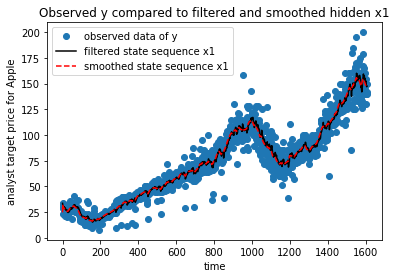

In [12]:
# Part C plot
import matplotlib.pyplot as plt
%matplotlib inline

xvals = list(range(n))
plt.figure()
plt.plot(xvals, y, 'o', label='observed data of y')
plt.plot(xvals, m[0,:].T, 'k-', label='filtered state sequence x1')
plt.plot(xvals, m_smooth[0,:].T, 'r--', label='smoothed state sequence x1')
plt.xlabel('time')
plt.ylabel('analyst target price for Apple')
plt.title('Observed y compared to filtered and smoothed hidden x1')
plt.legend(loc='best')